<a href="https://githubtocolab.com/EEESlab/APAI24-LAB01-DNN-definition-and-training/blob/master/APAI24-LAB1-DNN-definition-and-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/EEESlab/APAI24-LAB01-DNN-definition-and-training/HEAD?labpath=APAI24-LAB1-DNN-definition-and-training.ipynb)

# **Hardware/Software codesign of flexible computing systems for edge AI**
**PhD Course, Angelo Garofalo (ETH Zurich & University of Bologna), Jun 2025**


**LAB1: DNN Definition & Training**



**Credits**: *Davide Nadalini, Lorenzo Lamberti, Luca Bompani, Luka Macan, Francesco Conti*
*(University of Bologna)*

**Contacts**: *angelo.garofalo@unibo.it*



## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to define, train, and test a neural network over the Fashion-MNIST dataset.

### Tasks:

---

1.  PyTorch definition of a NN model;
2. Count network’s parameters and MAC operations;
3. Data loader for Fashion-MNIST
4. Code for testing a neural network on Fashion MNIST dataset;
5. Code for training a neural network on Fashion MNIST;
6. Save and load model’s trained weights;
---




## Let's start !

Let us start by installing dependencies...

**Note:** if you need to instal more packages, add them here! (but remember to also import them afterwards!)

In [ ]:
#@title Install dependencies { form-width: "20%" }

# these ones should already be available
!pip install numpy
!pip install tqdm
!pip install pillow

!pip install torch
!pip install torchvision

!pip install thop
!pip install matplotlib
!pip install scikit-learn
!pip install torchinfo

# You will need these if running on a private server (no colab)
# !pip install jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension



## Imports:
Now we import some packages  we will need:

In [ ]:
#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import time

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#torchvision
import torchvision
from torchvision import transforms, datasets

# others
from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect


## Set device
Between "cuda" and "cpu"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

# **Task 1:** Creating a Model
---



The first real step is to define the network topology. We will define a custom one.

* Use `torch.nn.Module`,
* **IMPORTANT:** Instantiate a separate `torch.nn.Module` for each node in your topology; This is mandatory for parametric modules (e.g., `torch.nn.Conv2d`, `nn.Linear`,`nn.BatchNorm2d`).

---

You can use the following modules:
* `nn.Conv2d`
* `nn.Linear`
* `nn.BatchNorm2d`
* `nn.ReLU`
* `nn.MaxPool2d`
* `nn.LogSoftmax`



**You must define the NN topology following this diagram:**

Note: set the padding of each Convolution to 1 to keep the size of the output feature map!

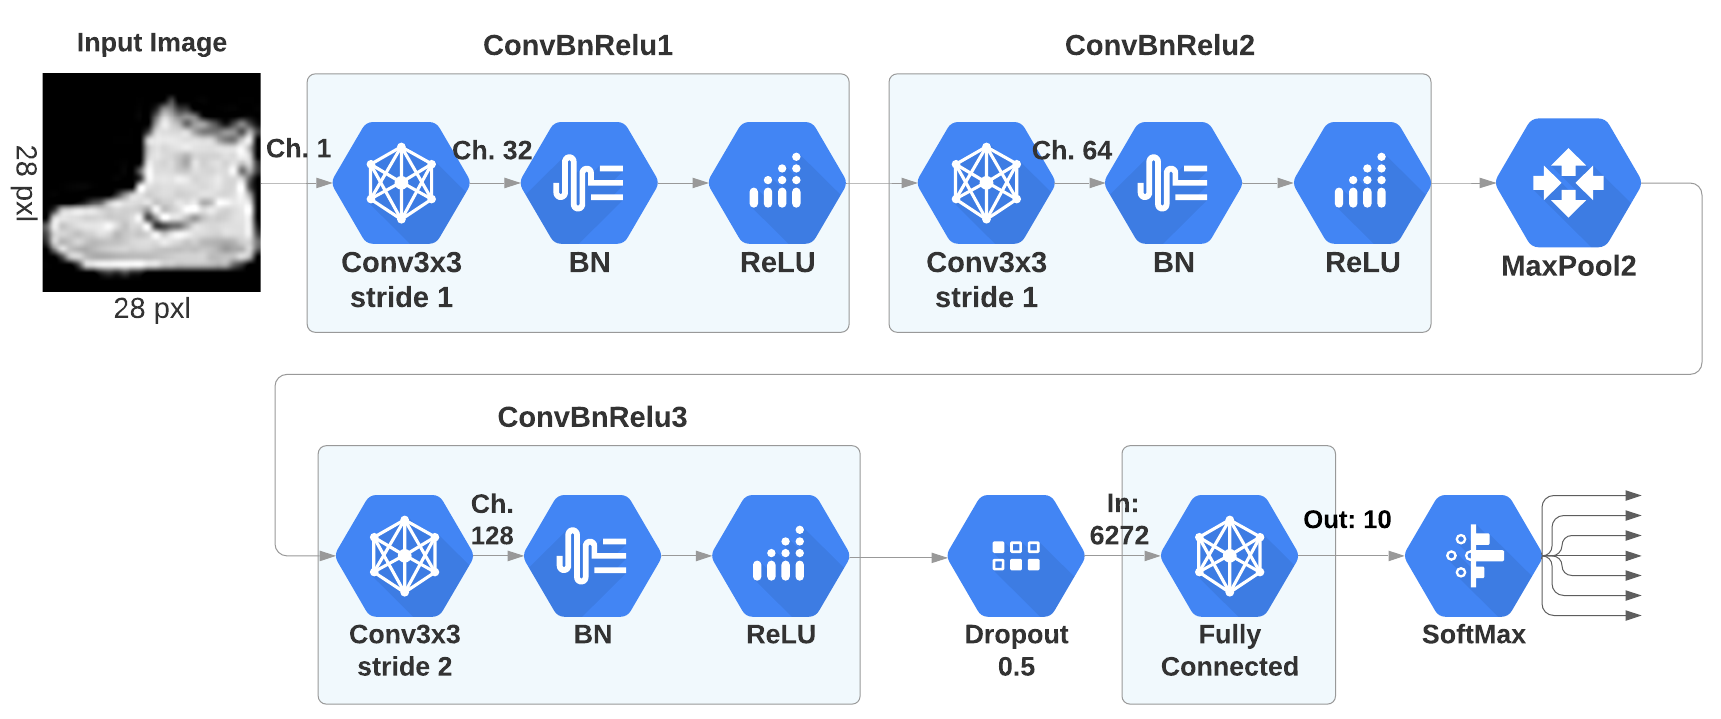

### This is how our network looks like:

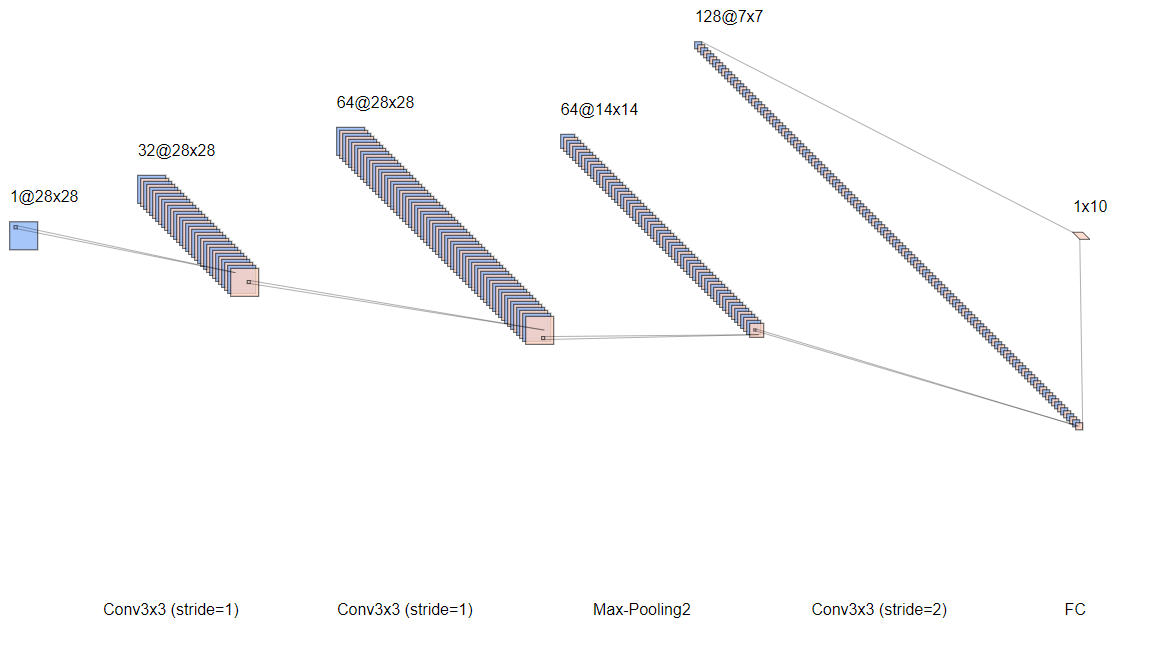

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # ......... # YOUR CODE GOES HERE

    def forward(self, x):
        # ......... # YOUR CODE GOES HERE
        return output

net = CNN().to(device)


### Test defined network, and verify layers




In [ ]:
#@title Dummy input  { form-width: "70%" }
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (1, 1, 28, 28)  #@param
input = torch.randn(input_size).to(device)#add one extra field to input size for batch_n


Print output tensor size and the CNN network topology defined:

In [ ]:
output = net(input)
print('Output shape:', output.shape)
print('Network Topology:\n',net)

# **Task 2:** Count network's parameters and MAC operations

---

Let's define a useful functions to measure the model's MAC operations and number of parameters!

In [ ]:
def network_size_and_mac(net, input_size, verbose=False):
    # calculate here
    # .....................
    # YOUR CODE GOES HERE
    # .....................
    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

test_net = CNN().to(device)
network_size_and_mac(test_net, input_size) #use deepcopy to avoid graph modifications by hese function calls

**TorchInfo insights:**
This tool calculates the Parameters Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

# **Task 3:** Dataset & DataLoaders

---

In this notebook we'll a custom CNN on the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.
This dataset is provided by the [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html).

Before diving in, let's look at the Fashion MNIST dataset. The dataset has 60 k training images and 10 k validation images. It has a total of 10 classes, each represented by an integer index. The following cell creates a mapping from these indices to their corresponding human-readable strings, then downloads the Fashion MNIST training dataset from Torchvision. It may take a minute to run.

Torchvision provides easy access to many datasets, including COCO, CIFAR, and Cityscapes. See its documentation for a complete list.

The dataset is stored on the Colab VM in the `/data/fashionmnist` directory.


Optional: diplay one image from the dataset
This might help you!

In [ ]:
#@title Show dataset image samples
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
fashion_mnist_dataset = # import fashion mnist with: torchvision.datasets. ......

# show one image from dataset
img_index = 0 #@param {type:"integer"}
tup = fashion_mnist_dataset[img_index] # tup = (image, label)
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

### Data loaders for Fashion MNIST



The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `train_dataset` contains the training data.
* `valid_dataset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [ ]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, path='./data/fashionmnist', verbose=False):
    #define data transformations
    fashion_mnist  = datasets.FashionMNIST(download=True, train=True, root=path).train_data.float()
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    # Load train/valid datasets
    train_dataset = ... # YOUR CODE GOES HERE
    valid_dataset = ... # YOUR CODE GOES HERE

    # define dataloaders
    train_loader = ... # YOUR CODE GOES HERE
    valid_loader = ... # YOUR CODE GOES HERE

    # count how many images we have in each set
    # .... # YOUR CODE GOES HERE

    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size, verbose=True)


# **Task 4:** testing the CNN over the dataset

---



### Accuracy Metric calculation

First we define a function to calculate the accuracy, defined as: `accuracy = num_correct_predictions/total_n_predictions`



In [ ]:
def calculate_accuracy(best_guesses, targets):
    num_correct = ...
    total_guesses = ...
    correct_percentage = num_correct/total_guesses
    return correct_percentage

### Define Loss function: use cross entropy !

In [ ]:
# Define loss function
loss_function = ... # cross entropy works well for multi-class problems
# YOUR CODE GOES HERE

### Testing Function
Before training we want to verify our data->network pipeline and set a baseline level of performance. The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [ ]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []

    # set net to evaluating (testing)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            # YOUR CODE GOES HERE
            outputs = ... # this gets the prediction from the network

            # calculate loss
            # YOUR CODE GOES HERE
            loss = ...
            val_losses.append(loss) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) #this is the same accuracy calculated with scikitlearn

    average_val_loss = sum(val_losses)/(batch_idx+1)
    return val_accuracy, average_val_loss


In [ ]:
val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

# **Task 5:** Training Loop

---



**Basic training in PyTorch:**
- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

In this case we'll use:
* **Loss Function:** [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) since we have a classification problem.
* **Optimizer:** We'll use the [Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer since it's a very easy optimizer to use (no need to tweak hyperparameters).

**Loops:**
*   for loop over `epochs`: at the end of each epoch we calculate the validation accuracy
*   for loop over `training batches`: for each batch we backpropagate using the loss function

**Training step:**
- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights


```
Pseudo-code:
├─ for each epoch (enumerate):
│  ├── for each training batch:
│  │  ├── output = net(input)
│  │  ├── loss = (output,ground_truth)
│  │  ├── net.zero_grad()
│  │  ├── loss.backward()
│  │  ├── optimizer step()
│  │  ├── calculate training accuracy
│  │  └── print: training accuracy and loss
│  └── test on validation set: print accuracy
```

We'll only train for 5 epochs for timeliness. The following cell should take 4-5 minutes to run.

### **Note: why do we need to reset the gradients**
In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero (`net.zero_grads()`)before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. So, the default action has been set to accumulate (i.e. sum) the gradients on every `loss.backward()` call.

I f you don't reset them, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

**in a nutshell:** if you don’t clear the gradients, they will accumulate across multiple iterations of training. This can lead to incorrect gradients and slower convergence of the model. Therefore, it’s important to clear the gradients before computing the gradients for the current iteration.

check out: https://saturncloud.io/blog/why-do-we-need-to-call-zerograd-in-pytorch/


In [ ]:
#@title Training parameters { form-width: "70%" }
epochs = 2 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [ ]:
# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

def training(net, train_loader, val_loader, loss_function, epochs):
    # Define optimizer
    # YOUR CODE GOES HERE
    optimizer = ....

    # count tot batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()

    # ----------------- TRAINING  -------------------- #
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        net.train() # set model to training
        # loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Compute prediction (forward input in the model)
            # YOUR CODE GOES HERE
            outputs =  ...
            # Compute prediction error with the loss function
            # YOUR CODE GOES HERE
            loss = ...
            # gradients to zero for every batch of data
            # YOUR CODE GOES HERE
            ...
            # Backpropagation
            # YOUR CODE GOES HERE
            ...
            # Optimizer step
            # YOUR CODE GOES HERE
            ...

            # getting training quality data
            current_loss = loss.item()

            # compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss/(batch_idx+1)

            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))

            average_train_accuracy = sum(train_accuracy)/(batch_idx+1)


        # ----------------- VALIDATION  ----------------- #
        # YOUR CODE GOES HERE
        val_accuracy, val_loss = ...

        # compute mean accuracy
        average_train_accuracy = sum(train_accuracy)/tot_train_batches
        average_val_accuracy = sum(val_accuracy)/tot_val_batches

        # print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch+1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(float(average_train_loss))
        val_loss_history.append(float(average_val_loss))
        train_accuracy_history.append(float(average_train_accuracy))
        val_accuracy_history.append(float(average_val_accuracy))

    print('Training time: %.1f seconds' % (time.time()-start_ts))

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history



In [ ]:
(train_loss_history,
train_accuracy_history,
val_loss_history,
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs)

We now re-evaluated our network's performance, and you will see an accuracy ~90%

### Plot training/validation loss
This is a good practice to track the training process. Uncomment them!

In [ ]:
# plt.plot(XXXXXX,label="Training Loss")
# plt.plot(YYYYYYY,label="Validation Loss")
# plt.xlabel('No. of Epochs')
# plt.ylabel('Accuracy & Loss')
# plt.legend(frameon=False)
# plt.show()

In [ ]:

# plt.plot(XXXXXX,label="Training Accuracy")
# plt.plot(YYYYYYY,label="Validation Accuracy")
# plt.xlabel('No. of Epochs')
# plt.ylabel('Accuracy & Loss')
# plt.ylim([0., 1.]) # limit y axis between 0 and 1
# plt.legend(frameon=False)
# plt.show()

# **Task 6:** Save/Load Model

---



In [ ]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


### Save a PyTorch Model

In [ ]:
#Save Pytorch model
def save_net(net,model_path, model_name):
    #Save Pytorch model
    # YOUR CODE GOES HERE
    ...

save_net(net,model_export_path, model_name)

### Load a PyTorch Model

In [ ]:
NEW_net = CNN().to(device)

# Load a PyTorch Model
def load_net(net, model_path, model_name, device):
    ''' Load a PyTorch Model '''
    checkpoint_file= join(model_path,model_name)
    # load weights file
    # YOUR CODE GOES HERE
    state_dict = ...
    # Load weights into the network
    # YOUR CODE GOES HERE
    ...
    # to device (cpu or gpu)
    net = CNN().to(device)
    return net

load_net(net, model_export_path, model_name, device)

Test again the network accuracy, to be sure that you saved/loaded weights correctly. You should get ~90% accuracy again.

In [ ]:
# Test over validation dataset
val_accuracy, average_val_loss = validate(NEW_net, val_loader, loss_function, accuracy_score)
# Print valid statistics
# YOUR CODE GOES HERE
# ......